In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/CIFAR-10/IID/CIFAR10_Main.ipynb'

**Step 2: Federated Learning with Flower**

---



Step 1 showed simple centralized training pipeline. All data was in one place. Next, we’ll simulate a situation where we have multiple datasets in multiple organizations and train a model over these organizations using federated learning.

Update model parameters

In federated learning, server sends global model parameters to client and client updates local model with parameters received from server. It then trains the model on the local data and sends the updated model parameters back to server.

We need two helper functions to update local model with parameters received from the server and to get updated model parameters from the local model: set_parameters and get_parameters.

In [3]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

*The set_parameters function updates the neural network (net) with given list of parameters received from server.*

*The get_parameters function extracts the current parameters (weights and biases) from the neural network (net) and converts them into a list of numpy.ndarray.*

Define the Flower ClientApp

In Flower, we create *ServerApp* and *ClientApp* to run the server-side and client-side code.

The first step toward creating a ClientApp is to implement subclasses of *flwr.client.Client* or *flwr.client.NumPyClient*.

For *NumpyClient* we need;


1.   get_parameters: return the current local model parameters
2.   fit: receive model parameters from server, train the model on local data and return the updated model parameters to the server
3.   evaluate: receive model parameters from server, evaluate the model on local data and return the evaluation result to the server

In [4]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [5]:
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

In [6]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    # config hold configurations related to training like number of epochs, learning rate, etc that control how the model is trained
    # or evaluated means hyperparameters
    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}
    # get_parameters(self.net) returns updated model parameters (weights and biases)
    # len(self.trainloader) returns number of training examples to perform weighted aggregation
    # {} optional metrics dictionary for loss, accuracy etc.

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

Class *FlowerClient* defines how local training/evaluation will be performed and allows *Flower* to call local training/evaluation through *fit* and *evaluate.*

Each instance of FlowerClient represents a single client in federated learning system.

*Flower* calls *FlowerClient.fit* on the instance when the server selects a particular client for training and *FlowerClient.evaluate* for evaluation.

*When training on a single machine, server and clients share CPU, GPU and memory.*

*Flower provides special simulation capabilities that create FlowerClient instance only when it is needed for training/evaluation and for this we need to implement a function client_fn.*

*In Flower, clients are identified as partition_id. We also create an instance of ClientApp and pass it the client_fn. ClientApp is the entrypoint that a running Flower client uses to call the code.*

In [7]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    # node_config fetch data partition associated to that node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    # FlowerClient is subclass of NumPyClient so we need to call .to_client() to convert it to subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

Define the Flower Server App

*On server side, to configure a strategy which encapsulates the federated learning approach, we use Federated Averaging (FedAvg).*

In [8]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [9]:
# strategy refers how the server manages the training process across multiple clients. It includes aggregation method, selection of clients,
# model evaluation etc.
strategy = FedAvg(
    fraction_fit=1.0,  # 100% of available clients for training
    fraction_evaluate=0.5,  # 50% of available clients for evaluation
    min_fit_clients=10,  # Never less than 10 clients for training
    min_evaluate_clients=5,  # Never less than 5 clients for evaluation
    min_available_clients=10,  # Wait until 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
)

*Also, we create ServerApp using a utility function server_fn. In server_fn, we pass an instance of ServerConfig for defining the number of federated learning rounds (num_rounds) and strategy. The server_fn returns ServerAppComponents object which contains the settings of ServerApp behaviour. ServerApp is the entrypoint that Flower uses to call server-side code.*

In [10]:
def server_fn(context: Context) -> ServerAppComponents:
    # Construct components that set the ServerApp behaviour.
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

Run the training

In [ ]:
# backend_config is a configuration object that contains parameters related to the backend of a federated
# learning setup (like the server).
# Flower Server: When starting the federated learning process, the server will use the backend_config to
# control how the rounds of training are managed, how clients are chosen, how long the server waits for
# client responses, etc.

In [11]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=10,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
(pid=3339) 2025-04-17 18:36:10.432322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=3339) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=3339) E0000 00:00:1744914970.453603    3339 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3339) E0000 00:00:1744914970.459695    3339 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=3339) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=3339) given by the platformdirs library.  To remove this warnin

Customized Federated Averaging for Plots

In [12]:
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [13]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [14]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=10,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1294) 2025-04-27 15:03:47.569611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1294) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1294) E0000 00:00:1745766227.616840    1294 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1294) E0000 00:00:1745766227.633261    1294 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1294) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

Round 1: Test Accuracy: 0.2224


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.4104


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.4840


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.5144


(ClientAppActor pid=1294) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1294) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Apr 27 15:04:38 2025).
(ClientAppActor pid=1294) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=1294) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Apr 27 15:04:38 2025).
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sample

Round 5: Test Accuracy: 0.5330


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.5708


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.5924


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.6084


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.6140


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 497.40s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07253135542869568
INFO :      		round 2: 0.05308680357933045
INFO :      		round 3: 0.04637309937477112
INFO :      		round 4: 0.04344173253774643
INFO :      		round 5: 0.041609666693210604
INFO :      		round 6: 0.03885639057159424
INFO :      		round 7: 0.03703271601200103
INFO :      		round 8: 0.034943335008621214
INFO :      		round 9: 0.034203917741775516
INFO :      		round 10: 0.03242367643117905
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.22240000000000001),
INFO :      	              (2, 0.4104),
INFO :      	              (3, 0.484),
INFO :      	              (4, 0.5144),
INFO :      	  

Round 10: Test Accuracy: 0.6472


In [15]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

Server side parameter initialization

*Flower initializes global model by asking one random client for the initial parameters by default. Flower allows to directly pass the initial parameters to the Strategy.*

In [23]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

In [ ]:
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    # Passing initial_parameters to FedAvg strategy prevents Flower from asking one of the clients.
    initial_parameters=ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=10,
    backend_config=backend_config,
)

(pid=48573) 2025-04-17 21:07:07.253835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=48573) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=48573) E0000 00:00:1744924027.275009   48573 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=48573) E0000 00:00:1744924027.282466   48573 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=48573) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=48573) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=48573) see the 

Round 1: Test Accuracy: 0.1968
Round 2: Test Accuracy: 0.3948
Round 3: Test Accuracy: 0.4596
Round 4: Test Accuracy: 0.5068
Round 5: Test Accuracy: 0.5468
Round 6: Test Accuracy: 0.5708
Round 7: Test Accuracy: 0.5806
Round 8: Test Accuracy: 0.5950
Round 9: Test Accuracy: 0.6280
Round 10: Test Accuracy: 0.6322


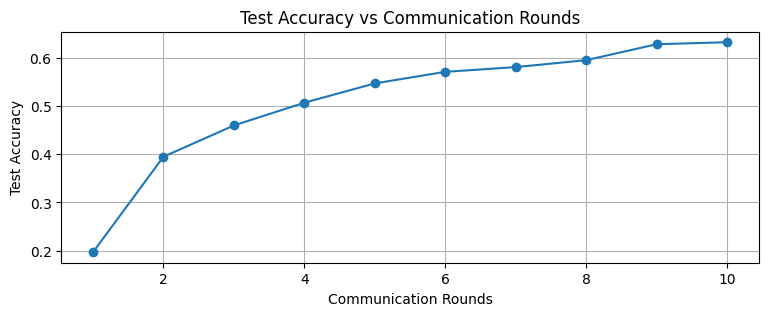

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

Starting with a customized strategy

*The function run_simulation accepts number of arguments, such as*
1. *server_app which wraps around the strategy and number of training rounds*
2. *client_app which wraps around the client_fn used to create FlowerClient instances and number of clients to simulate which equals num_supernodes.*

FedAdagrad

---



In [24]:
from flwr.server.strategy import FedAdagrad
# FedAdagrad strategy instead of FedAvg strategy

In [25]:
test_accuracies = []

class CustomFedAdagrad(FedAdagrad):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [26]:
strategy = CustomFedAdagrad(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=weighted_average,
    )

In [27]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=10,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=9220) 2025-04-27 15:23:19.208320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=9220) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=9220) E0000 00:00:1745767399.240306    9220 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=9220) E0000 00:00:1745767399.250521    9220 cuda_blas.cc:1418] Unable to register cuBLAS factory: A

Round 1: Test Accuracy: 0.1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.1022


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.0786


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.0972


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.1054


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.0940


(ClientAppActor pid=9220) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=9220) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Apr 27 15:04:38 2025).
(ClientAppActor pid=9220) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=9220) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Apr 27 15:04:38 2025).
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sample

Round 7: Test Accuracy: 0.1034


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.0954


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.0962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 518.35s
INFO :      	History (loss, distributed):
INFO :      		round 1: 11.2189052154541
INFO :      		round 2: 0.47802515821456915
INFO :      		round 3: 0.10563699860572814
INFO :      		round 4: 0.07379094614982606
INFO :      		round 5: 0.0736882272720337
INFO :      		round 6: 0.07370939946174622
INFO :      		round 7: 0.07369320640563964
INFO :      		round 8: 0.07369353752136229
INFO :      		round 9: 0.07369068422317505
INFO :      		round 10: 0.07368973684310913
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.11979999999999999),
INFO :      	              (2, 0.1022),
INFO :      	              (3, 0.07860000000000002),
INFO :      	              (4, 0.097200000000000

Round 10: Test Accuracy: 0.0948


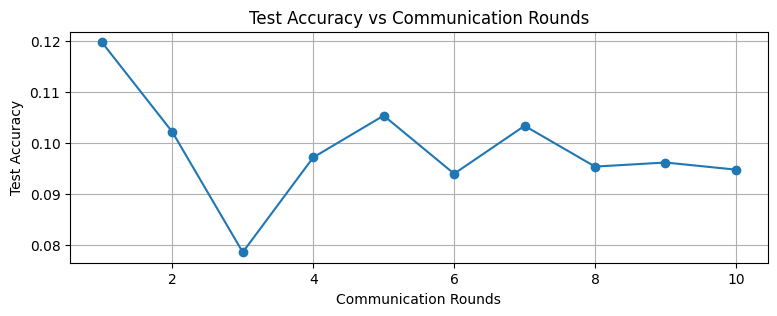

In [28]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()